In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Augmentation function
def augment_audio(y_audio, sr):
    if np.random.rand() > 0.5:
        y_audio = librosa.effects.time_stretch(y_audio, rate=np.random.uniform(0.8, 1.2))
    if np.random.rand() > 0.5:
        y_audio = librosa.effects.pitch_shift(y_audio, sr=sr, n_steps=np.random.randint(-2, 3))
    return y_audio


In [4]:
# Feature extraction function
def extract_features(dataset_path, target_categories, max_files_per_category=3480, target_length=128):
    category_dict = {category: idx for idx, category in enumerate(target_categories)}  # Filtered categories
    
    X, y = [], []
    audio_extensions = ['.wav', '.mp3', '.flac']  # List of valid audio file extensions
    
    for category in target_categories:
        category_path = os.path.join(dataset_path, category)
        
        # List audio files in the subdirectory
        files = [f for f in os.listdir(category_path) if any(f.endswith(ext) for ext in audio_extensions)]
        files = files[:max_files_per_category]
        
        for file in files:
            file_path = os.path.join(category_path, file)
            try:
                y_audio, sr = librosa.load(file_path, sr=None)
                
                # Apply augmentation
                y_audio = augment_audio(y_audio, sr)
                
                # Apply Mel spectrogram transformation with dynamic n_fft adjustment
                n_fft = min(len(y_audio), 2048)  # Ensure n_fft is not larger than the signal length
                mel_spectrogram = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=128, fmax=8000, n_fft=n_fft)
                mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                
                # Pad or truncate to ensure consistent shape
                if mel_spectrogram.shape[1] > target_length:
                    mel_spectrogram = mel_spectrogram[:, :target_length]
                else:
                    pad_width = target_length - mel_spectrogram.shape[1]
                    mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
  
                X.append(mel_spectrogram)
                y.append(category_dict[category])
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    return X, y, target_categories              

In [5]:
# Load dataset with filtered categories
dataset_path = '/kaggle/input/urdu-8emotions-24actors-dataset/normalized/'

# Define the specific categories we want to use
target_categories = ["Anger", "Happiness", "Sadness", "Neutral"]

X, y, category_names = extract_features(dataset_path, target_categories)
X = X[..., np.newaxis]  # Add channel dimension for CNN (e.g., (128, 128, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=795
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=707
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [6]:
# Build ResNet model
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the ResNet layers
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Define model parameters
input_shape = (128, 128, 3)  # Assuming Mel-spectrograms are expanded to 3 channels (RGB)
num_classes = len(category_names)

# Convert grayscale spectrograms to 3 channels
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Build and train the model
model = build_resnet_model(input_shape, num_classes)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30


I0000 00:00:1732990959.606673     122 service.cc:145] XLA service 0x7e6fe80014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732990959.606720     122 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/279 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2608 - loss: 2.2582 

I0000 00:00:1732990964.943803     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


279/279 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.5462 - loss: 1.1303 - val_accuracy: 0.7409 - val_loss: 0.6524
Epoch 2/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7159 - loss: 0.6988 - val_accuracy: 0.7643 - val_loss: 0.6037
Epoch 3/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7467 - loss: 0.6243 - val_accuracy: 0.7822 - val_loss: 0.5504
Epoch 4/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7660 - loss: 0.5717 - val_accuracy: 0.8069 - val_loss: 0.4891
Epoch 5/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7874 - loss: 0.5307 - val_accuracy: 0.8141 - val_loss: 0.4769
Epoch 6/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8014 - loss: 0.4982 - val_accuracy: 0.8231 - val_loss: 0.4512
Epoch 7/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8224 - loss: 0.4572 - val_accuracy: 0.8033 - val_loss: 0.4880
Epoch 8/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8236 - loss: 0.4532 - val_accuracy: 0.81

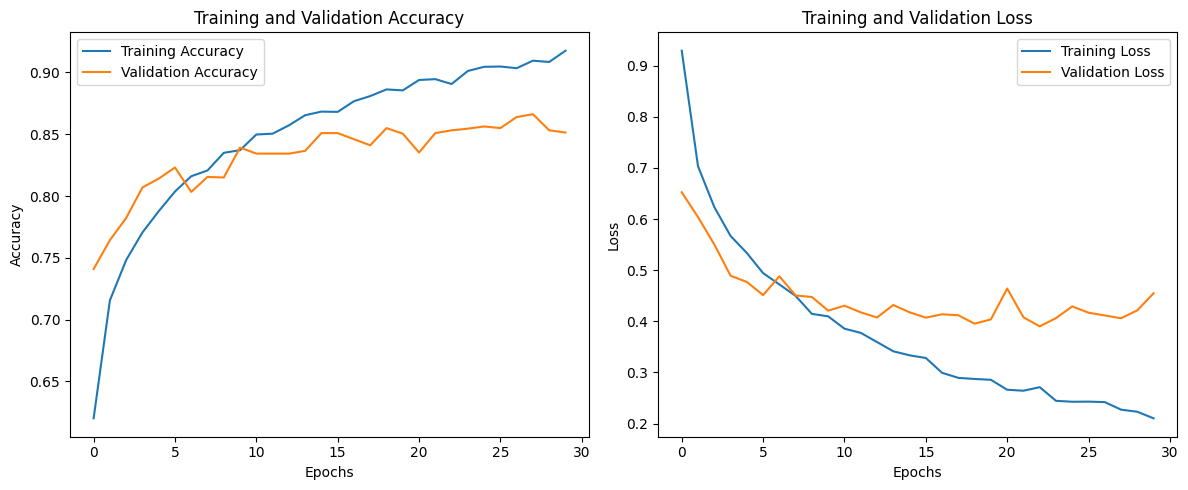

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


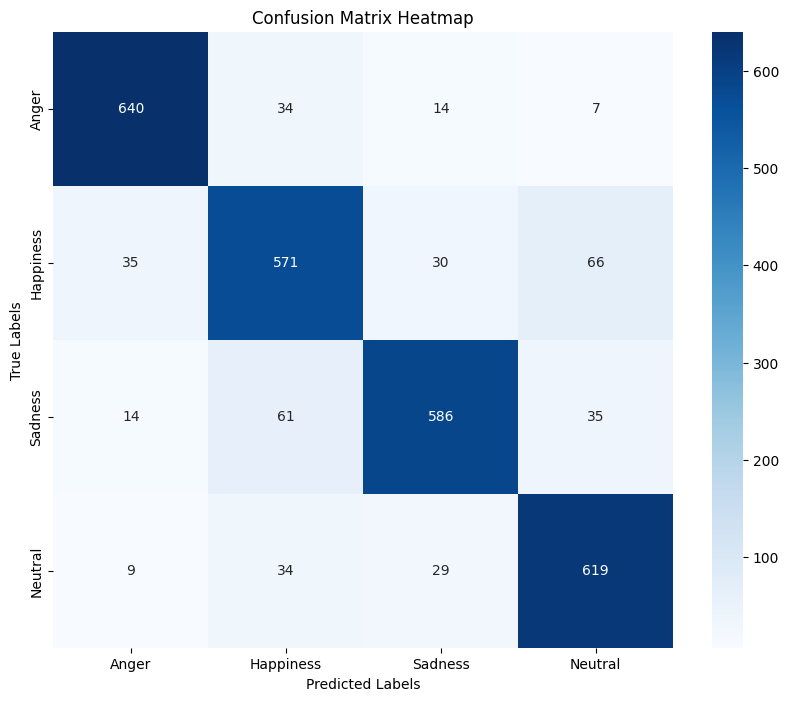

In [8]:
# Plot training history for accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
